<a href="https://colab.research.google.com/github/Piyushiitk24/dc-motor-signed-bias-deadzone-id-control/blob/main/DC_Motor_ID_SignedBias_DeadZone_IMCPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SECTION 0 — Setup & Mount Drive

In [3]:
# --- SECTION 0: Setup & Mount Drive ---
import warnings; warnings.filterwarnings('ignore')

# Mount Google Drive (works in Colab; no-op elsewhere)
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
except Exception:
    pass

# Paths (edit if needed)
CSV_PATH  = '/content/drive/MyDrive/Master_Archive/60_Academics/Projects/Thesis/run_minimal.csv'
MAP_PATH  = '/content/drive/MyDrive/Master_Archive/60_Academics/Projects/Thesis/Voltage_PWM_RPM_Mapping.csv'
OUT_DIR   = '/content/drive/MyDrive/Master_Archive/60_Academics/Projects/Thesis'

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter, lsim, TransferFunction
from scipy.interpolate import PchipInterpolator
from numpy.polynomial import Chebyshev

print("Setup complete.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setup complete.


## SECTION 1 — Load Voltage–PWM–RPM Mapping + Build Mappers

In [4]:
# --- SECTION 1: Load Voltage–PWM–RPM Mapping + Build Mappers ---

# Load mapping table
map_df = pd.read_csv(MAP_PATH)

# Normalize column names (accepts any case)
map_df.columns = [c.strip().lower() for c in map_df.columns]
required = {'voltage','pwm','rpm'}
assert required.issubset(set(map_df.columns)), f"Mapping CSV must contain columns: {required}"

# Keep the three columns, sort by voltage, average duplicates (helps interpolation)
map_df = (map_df[['voltage','pwm','rpm']]
          .dropna()
          .groupby('voltage', as_index=False)
          .agg({'pwm':'median','rpm':'median'})
          .sort_values('voltage')
          .reset_index(drop=True))

V_map = map_df['voltage'].to_numpy(dtype=float)
P_map = map_df['pwm'].to_numpy(dtype=float)
R_map = map_df['rpm'].to_numpy(dtype=float)

# --- 1A) Shape-preserving LUTs (recommended) ---
# Voltage -> PWM (primary mapper for control)
pchip_V2P = PchipInterpolator(V_map, P_map, extrapolate=True)
# PWM -> Voltage (useful for cross-checks/tools)
# For reverse mapping, sort by PWM and average duplicates
_rev = (pd.DataFrame({'pwm':P_map,'voltage':V_map})
        .groupby('pwm', as_index=False).agg({'voltage':'median'})
        .sort_values('pwm').reset_index(drop=True))
pchip_P2V = PchipInterpolator(_rev['pwm'].to_numpy(float),
                              _rev['voltage'].to_numpy(float),
                              extrapolate=True)

# --- 1B) Optional explicit function (Chebyshev polynomial) ---
# Pick degree via BIC to avoid silly overfit while staying precise (deg 3..8)
def fit_cheby_bic(x, y, deg_range=range(3,9)):
    x = np.asarray(x, float); y = np.asarray(y, float)
    n = len(x)
    best = {'deg': None, 'bic': np.inf, 'model': None}
    dom = [float(x.min()), float(x.max())]
    for deg in deg_range:
        ch = Chebyshev.fit(x, y, deg=deg, domain=dom)
        yhat = ch(x)
        rss = float(np.sum((y - yhat)**2))
        p = deg + 1  # number of coefficients
        # BIC = n*ln(RSS/n) + p*ln(n)
        bic = n*np.log(rss/max(n,1)) + p*np.log(max(n,1))
        if bic < best['bic']:
            best = {'deg': deg, 'bic': bic, 'model': ch}
    return best

cheby_fit = fit_cheby_bic(V_map, P_map)  # Voltage -> PWM
cheby_model = cheby_fit['model']  # can be None if something odd happens

# --- 1C) Deadband estimate from mapping (RPM threshold) ---
RPM_THRESHOLD = 30.0  # change if your motor "starts moving" at a different RPM
candidates = map_df.loc[map_df['rpm'] >= RPM_THRESHOLD, 'voltage']
V_DEADBAND_EST = float(candidates.iloc[0]) if len(candidates) else float(map_df['voltage'].min())

print(f"Mapping rows: {len(map_df)} | Deadband estimate ≈ {V_DEADBAND_EST:.2f} V | Chebyshev degree: {cheby_fit['deg']}")

Mapping rows: 40 | Deadband estimate ≈ 2.08 V | Chebyshev degree: 5


## SECTION 2 — Unified Mapping API (+ quick check)

In [5]:
# --- SECTION 2: Unified Voltage→PWM / PWM→Voltage mapping API ---

def _clip_pwm(x):
    return np.clip(np.asarray(x, dtype=float), 0, 255)

def _to_1d(a):
    return np.asarray(a, dtype=float).reshape(-1)

# Default deadband used by the mapper (you can override per call)
VDB_POS_DEFAULT = 4.5  # your original constant
VDB_NEG_DEFAULT = 4.5  # your original constant
USE_AUTO_DEADBAND = False  # set True to use the estimate from mapping

def voltage_to_pwm_lookup(v, vdb_pos=None, vdb_neg=None, round_to_int=True):
    v = _to_1d(v)
    vdb_pos = V_DEADBAND_EST if (USE_AUTO_DEADBAND and vdb_pos is None) else (vdb_pos if vdb_pos is not None else VDB_POS_DEFAULT)
    vdb_neg = V_DEADBAND_EST if (USE_AUTO_DEADBAND and vdb_neg is None) else (vdb_neg if vdb_neg is not None else VDB_NEG_DEFAULT)
    vdb = np.where(v >= 0.0, vdb_pos, vdb_neg)
    pwm = np.where(np.abs(v) < vdb, 0.0, pchip_V2P(v))
    pwm = _clip_pwm(pwm)
    return pwm.astype(int) if round_to_int else pwm

def voltage_to_pwm_cheby(v, vdb_pos=None, vdb_neg=None, round_to_int=True):
    assert cheby_model is not None, "Chebyshev model not available."
    v = _to_1d(v)
    vdb_pos = V_DEADBAND_EST if (USE_AUTO_DEADBAND and vdb_pos is None) else (vdb_pos if vdb_pos is not None else VDB_POS_DEFAULT)
    vdb_neg = V_DEADBAND_EST if (USE_AUTO_DEADBAND and vdb_neg is None) else (vdb_neg if vdb_neg is not None else VDB_NEG_DEFAULT)
    vdb = np.where(v >= 0.0, vdb_pos, vdb_neg)
    pwm = np.where(np.abs(v) < vdb, 0.0, cheby_model(v))
    pwm = _clip_pwm(pwm)
    return pwm.astype(int) if round_to_int else pwm

def pwm_to_voltage_lookup(pwm):
    pwm = _to_1d(pwm)
    return pchip_P2V(_clip_pwm(pwm))

def voltage_to_pwm(v, method='lookup', **kwargs):
    """method: 'lookup' (PCHIP, recommended) or 'cheby' (explicit polynomial)."""
    if method == 'lookup':
        return voltage_to_pwm_lookup(v, **kwargs)
    elif method == 'cheby':
        return voltage_to_pwm_cheby(v, **kwargs)
    else:
        raise ValueError("method must be 'lookup' or 'cheby'")

# Quick sanity check
print("Voltage→PWM (lookup):", voltage_to_pwm([0, 4.0, 4.6, 6.0, 8.0], method='lookup'))
print("PWM→Voltage (lookup):", pwm_to_voltage_lookup([0, 64, 128, 192, 255]))

Voltage→PWM (lookup): [  0   0  54  76 168]
PWM→Voltage (lookup): [0.01       5.22876767 7.51787877 8.32666871 8.81      ]


## SECTION 3 — (Optional) Visualize Mapping

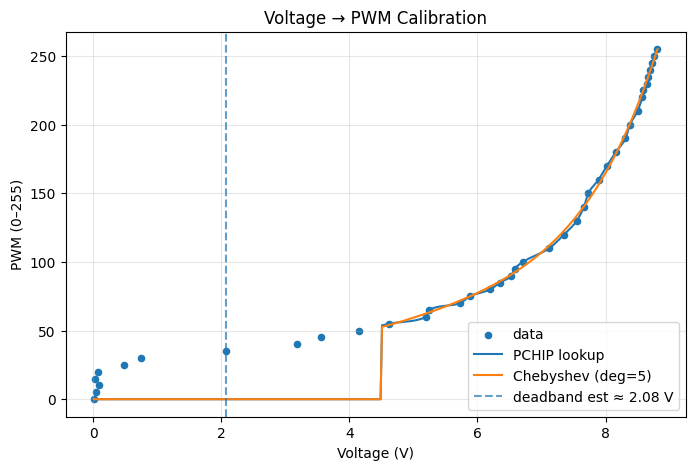

In [6]:
# --- SECTION 3: (Optional) Visualize Mapping ---
V_grid = np.linspace(float(map_df['voltage'].min()), float(map_df['voltage'].max()), 400)

plt.figure(figsize=(8,5))
plt.scatter(map_df['voltage'], map_df['pwm'], s=20, label='data')
plt.plot(V_grid, voltage_to_pwm(V_grid, method='lookup', round_to_int=False), label='PCHIP lookup')
if cheby_model is not None:
    plt.plot(V_grid, voltage_to_pwm(V_grid, method='cheby', round_to_int=False), label=f'Chebyshev (deg={cheby_fit["deg"]})')
plt.axvline(V_DEADBAND_EST, ls='--', alpha=0.7, label=f'deadband est ≈ {V_DEADBAND_EST:.2f} V')
plt.xlabel('Voltage (V)'); plt.ylabel('PWM (0–255)'); plt.title('Voltage → PWM Calibration')
plt.grid(True, alpha=0.3); plt.legend()
plt.show()

## SECTION 4 — Load Run Data & Preprocessing (your original)

In [7]:
# --- SECTION 4: Load run_minimal.csv & Preprocessing ---

# load csv
df = pd.read_csv(CSV_PATH)
df['time']    = pd.to_numeric(df['time'],    errors='coerce')
df['voltage'] = pd.to_numeric(df['voltage'], errors='coerce')
df['rpm']     = pd.to_numeric(df['rpm'],     errors='coerce')

# sampling
t_vals = df['time'].values
Ts = float(np.median(np.diff(t_vals))) if len(df) > 1 else 0.01
Ts = max(Ts, 1e-3)

# dead-zone (before plant) — keep your constants; you can flip USE_AUTO_DEADBAND=True above if preferred
VDB_POS, VDB_NEG, SOFT_ALPHA = VDB_POS_DEFAULT, VDB_NEG_DEFAULT, 0.00

def deadzone_map(u):
    u = np.asarray(u, dtype=float)
    vdb = np.where(u >= 0.0, VDB_POS, VDB_NEG)
    mag = np.abs(u)
    eff_mag = np.where(mag <= vdb, SOFT_ALPHA * mag, (mag - vdb) + SOFT_ALPHA * vdb)
    return np.sign(u) * eff_mag

df['u_eff'] = deadzone_map(df['voltage'].values)

# smooth rpm (for ID)
y_raw = df['rpm'].values
base_win = int(round(0.5 / Ts));  base_win += (base_win % 2 == 0)
base_win = max(5, min(base_win, len(df) - (len(df) % 2 == 0)))
y_id = savgol_filter(y_raw, window_length=base_win, polyorder=2, mode='interp')
df['rpm_id'] = y_id

print("Loaded main run and preprocessed.")

Loaded main run and preprocessed.


## SECTION 5 — Step Detection & Per-Step Fits (your original)

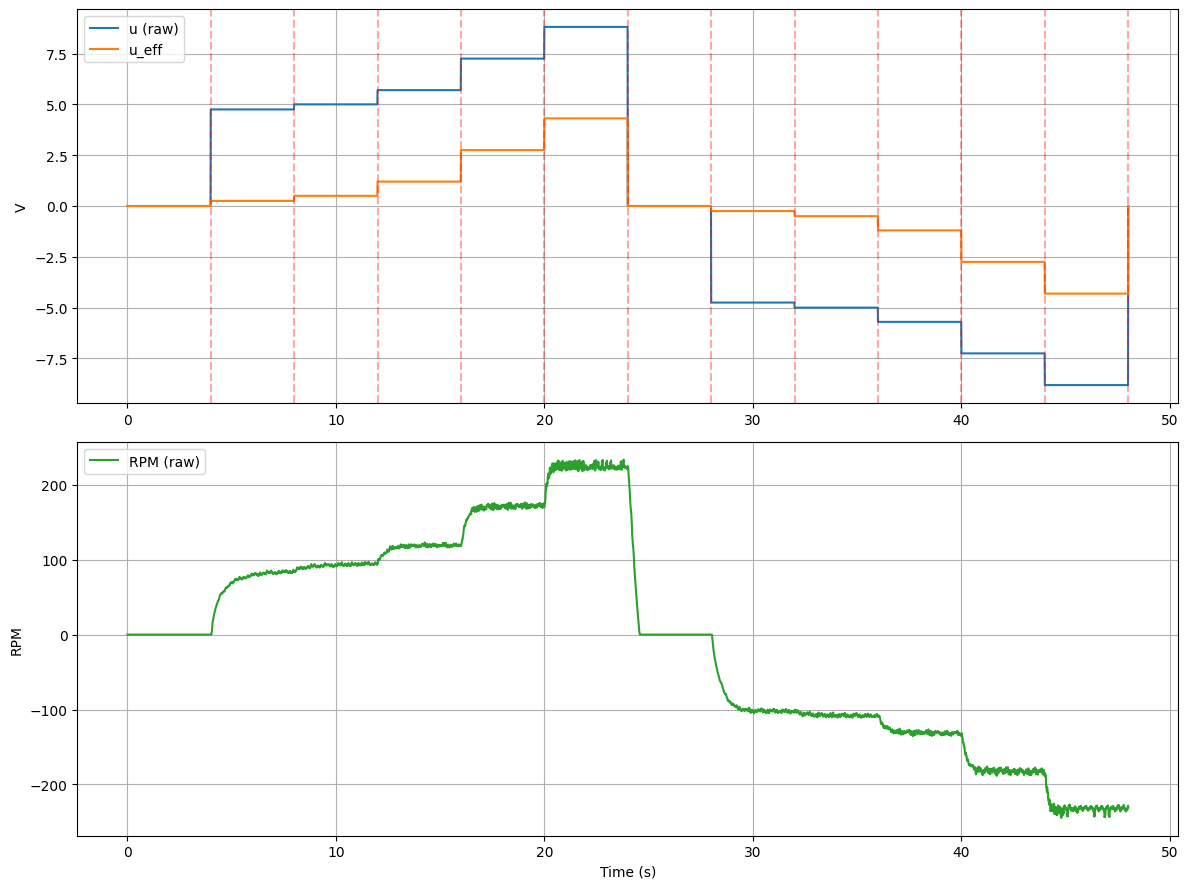

<Figure size 640x480 with 0 Axes>

Candidates: ['Step1', 'Step2', 'Step3', 'Step4', 'Step5', 'Step6', 'Step7', 'Step8', 'Overall', 'Up_avg', 'Down_avg']


In [8]:
thrV = max(0.2, 4.0 * stats.median_abs_deviation(np.diff(df["voltage"].values), scale='normal'))
changes = [0] + [i for i in range(1, len(df))
                 if abs(df["voltage"].iloc[i] - df["voltage"].iloc[i-1]) >= thrV] + [len(df)]

MIN_DV      = 0.5
MIN_DWELLN  = int(2.0 / Ts)

def step_model(t, dy, tau):
    return dy * (1.0 - np.exp(-t / tau))

def compute_mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def _savgol_len(n, prefer):
    w = min(prefer, n if (n % 2 == 1) else (n - 1))
    if w < 5: w = 5
    if w % 2 == 0: w += 1
    return w

step_results = []

# quick visual incl. steps (full run)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
ax1.plot(df['time'], df['voltage'], label='u (raw)')
ax1.plot(df['time'], df['u_eff'],   label='u_eff')
for k in range(1, len(changes)-1):
    ax1.axvline(df['time'].iloc[changes[k]], color='r', ls='--', alpha=0.35)
ax1.set_ylabel('V'); ax1.grid(True); ax1.legend(loc='upper left')
ax2.plot(df['time'], y_raw, label='RPM (raw)', color='tab:green')
ax2.set_xlabel('Time (s)'); ax2.set_ylabel('RPM'); ax2.grid(True); ax2.legend(loc='upper left')
plt.tight_layout(); plt.show()

prev_u = df['voltage'].iloc[0]
for seg in range(len(changes) - 1):
    s = changes[seg]
    e = changes[seg + 1] - 1
    if s > e: continue

    seg_df   = df.iloc[s:e+1].copy()
    t0       = float(seg_df['time'].iloc[0])
    t_seg    = seg_df['time'] - t0
    u_after  = float(seg_df['voltage'].iloc[0])
    u_before = float(prev_u)
    du_raw   = u_after - u_before

    if len(seg_df) < MIN_DWELLN: prev_u = u_after; continue
    if abs(du_raw) < MIN_DV:     prev_u = u_after; continue

    raw_seg   = y_raw[s:e+1]
    prefer    = 101 if abs(du_raw) < 1.0 else 51
    win_len   = _savgol_len(len(raw_seg), prefer)
    y         = savgol_filter(raw_seg, window_length=win_len, polyorder=2, mode='interp')

    y0, yss   = float(y[0]), float(y[-1])
    dy_guess  = yss - y0
    if abs(dy_guess) < 5: prev_u = u_after; continue

    tau0 = max(0.05, min(2.0, (seg_df['time'].iloc[-1] - seg_df['time'].iloc[0]) / 3.0))
    p0   = [dy_guess, tau0]
    lb_tau, ub_tau = 0.02, 5.0
    if dy_guess >= 0: lb_dy, ub_dy = 0.3*dy_guess, 1.7*dy_guess
    else:             lb_dy, ub_dy = 1.7*dy_guess, 0.3*dy_guess

    du_eff = deadzone_map([u_after])[0] - deadzone_map([u_before])[0]

    try:
        popt, _ = curve_fit(step_model, t_seg, y - y0,
                            p0=p0, bounds=([lb_dy, lb_tau],[ub_dy, ub_tau]), maxfev=5000)
        dy_fit, tau_fit = float(popt[0]), float(popt[1])
        K_fit = dy_fit / du_eff if abs(du_eff) > 1e-6 else np.nan

        yhat = y0 + step_model(t_seg.values, dy_fit, tau_fit)
        mae  = compute_mae(y, yhat)
        if np.isnan(mae) or mae > 5: prev_u = u_after; continue

        step_results.append({
            'step_num': len(step_results) + 1,
            'start_time': t0, 'start_idx': int(s), 'end_idx': int(e),
            'u_before': u_before, 'u_after': u_after,
            'delta_u': du_raw, 'delta_u_eff': float(du_eff),
            'y0': y0, 'y_ss': yss,
            'delta_y_fit': dy_fit, 'K': float(K_fit), 'tau': tau_fit,
            'mae_rpm': mae,
            'direction': seg_df['direction'].iloc[0] if 'direction' in seg_df.columns else 'up',
            'window_len': int(win_len)
        })

        tt = np.linspace(0, t_seg.iloc[-1], 200)
        ax2.plot(t0 + tt, y0 + step_model(tt, dy_fit, tau_fit), '--', alpha=0.6)

    except Exception:
        pass

    prev_u = u_after

plt.tight_layout(); plt.show()
assert step_results, "No valid steps found."

valid = [r for r in step_results if not np.isnan(r['K'])]
K_all   = [r['K'] for r in valid]
tau_all = [r['tau'] for r in valid]
overall_K, overall_tau = float(np.mean(K_all)), float(np.mean(tau_all))

def _dir(r):
    return (r['direction'].strip().lower() if isinstance(r['direction'], str)
            else ('up' if r['direction']>0 else 'down'))

up   = [r for r in valid if _dir(r)=='up']
down = [r for r in valid if _dir(r)=='down']
up_K   = float(np.mean([r['K'] for r in up]))   if up else np.nan
up_tau = float(np.mean([r['tau'] for r in up])) if up else np.nan
dn_K   = float(np.mean([r['K'] for r in down])) if down else np.nan
dn_tau = float(np.mean([r['tau'] for r in down])) if down else np.nan

# Save per-step table for reference
pd.DataFrame(step_results).to_csv(f'{OUT_DIR}/step_fits.csv', index=False)

# Build candidates
candidates = [{'name': f"Step{r['step_num']}", 'K': r['K'], 'tau': r['tau']} for r in valid]
candidates += [{'name':'Overall','K':overall_K,'tau':overall_tau}]
if not np.isnan(up_K):   candidates += [{'name':'Up_avg','K':up_K,'tau':up_tau}]
if not np.isnan(dn_K):   candidates += [{'name':'Down_avg','K':dn_K,'tau':dn_tau}]
print("Candidates:", [c['name'] for c in candidates])

## SECTION 6 — Simulation Helpers (bias/delay search) (your original)

In [19]:
# --- SECTION 6: Simulation helpers (signed bias + delay) ---

# delay helper
def apply_delay(u, t, Td):
    if Td <= 1e-9:
        return np.asarray(u, dtype=float).copy()
    t = np.asarray(t, dtype=float); u = np.asarray(u, dtype=float)
    return np.interp(t, t - float(Td), u, left=u[0], right=u[-1])

# linear plant response y for input u
def sim_full_response(K, tau, u_input, t_input):
    sys = TransferFunction([K], [tau, 1.0])
    _, yout, _ = lsim(sys, U=u_input, T=t_input, X0=0.0)
    return yout

# one-shot builder for overlays: y = L{ uD - Bp*1{uD>0} + Bn*1{uD<0} }
def sim_full_signed_bias(K, tau, u_eff, t, Bpos, Bneg, D):
    uD   = apply_delay(u_eff, t, D)
    pos  = (uD > 0).astype(float)
    neg  = (uD < 0).astype(float)
    y_u   = sim_full_response(K, tau, uD,  t)
    y_pos = sim_full_response(K, tau, pos, t)
    y_neg = sim_full_response(K, tau, neg, t)
    return y_u - Bpos * y_pos + Bneg * y_neg

# fast search for (Bpos, Bneg, D) using 3 sims per delay
def fit_signed_bias_delay_fast(K, tau, u_eff, t, y_true, mask,
                               bias_pos_bounds=(-5.0, 5.0), bias_neg_bounds=(-5.0, 5.0),
                               delay_bounds=(0.0, 0.30),
                               coarse_B_n=17, coarse_D_n=19,
                               fine_B_n=9, fine_D_n=9):
    idx = np.where(mask)[0]
    best = {'Bpos':0.0,'Bneg':0.0,'D':0.0,'mae':np.inf}

    Bs_pos = np.linspace(*bias_pos_bounds, coarse_B_n)
    Bs_neg = np.linspace(*bias_neg_bounds, coarse_B_n)
    Ds     = np.linspace(*delay_bounds,    coarse_D_n)

    for D in Ds:
        uD   = apply_delay(u_eff, t, D)
        pos  = (uD > 0).astype(float)
        neg  = (uD < 0).astype(float)

        # 3 sims reused for all Bp/Bn at this D
        y_u   = sim_full_response(K, tau, uD,  t)
        y_pos = sim_full_response(K, tau, pos, t)
        y_neg = sim_full_response(K, tau, neg, t)

        yu, yp, yn, yt = y_u[idx], y_pos[idx], y_neg[idx], y_true[idx]

        # vectorized sweep on Bneg for each Bpos
        for Bp in Bs_pos:
            base = yu - Bp * yp                        # [N]
            yhat = base[:, None] + yn[:, None] * Bs_neg[None, :]   # [N x Nb]
            mae_vec = np.mean(np.abs(yt[:, None] - yhat), axis=0)  # [Nb]
            j = int(np.argmin(mae_vec)); mae = float(mae_vec[j])
            if mae < best['mae']:
                best.update({'Bpos':float(Bp),'Bneg':float(Bs_neg[j]),'D':float(D),'mae':mae})

    # fine grid around current best
    Bp0, Bn0, D0 = best['Bpos'], best['Bneg'], best['D']
    Bs_pos_f = np.linspace(Bp0-0.30, Bp0+0.30, fine_B_n)
    Bs_neg_f = np.linspace(Bn0-0.30, Bn0+0.30, fine_B_n)
    Ds_f     = np.linspace(max(delay_bounds[0], D0-0.05),
                           min(delay_bounds[1], D0+0.05), fine_D_n)

    for D in Ds_f:
        uD   = apply_delay(u_eff, t, D)
        pos  = (uD > 0).astype(float)
        neg  = (uD < 0).astype(float)
        y_u   = sim_full_response(K, tau, uD,  t)
        y_pos = sim_full_response(K, tau, pos, t)
        y_neg = sim_full_response(K, tau, neg, t)
        yu, yp, yn, yt = y_u[idx], y_pos[idx], y_neg[idx], y_true[idx]
        for Bp in Bs_pos_f:
            base = yu - Bp * yp
            yhat = base[:, None] + yn[:, None] * Bs_neg_f[None, :]
            mae_vec = np.mean(np.abs(yt[:, None] - yhat), axis=0)
            j = int(np.argmin(mae_vec)); mae = float(mae_vec[j])
            if mae < best['mae']:
                best.update({'Bpos':float(Bp),'Bneg':float(Bs_neg_f[j]),'D':float(D),'mae':mae})

    return best['Bpos'], best['Bneg'], best['D'], best['mae']

# per-step sim (no bias/delay) used for step-wise CV
def sim_step_response(t, du_raw, K, tau, y0, u_before=None, u_after=None):
    if (u_before is not None) and (u_after is not None):
        du_eff = deadzone_map([u_after])[0] - deadzone_map([u_before])[0]
    else:
        du_eff = du_raw
    return y0 + (K * du_eff) * (1.0 - np.exp(-t / max(tau, 1e-9)))

## SECTION 7 — Cross-Validation (Bias/Delay), Overlays, Heatmap (your original)

In [20]:
# --- SECTION 7: Cross-Validation, Overlays, Heatmap ---

# Choose what portion of the run to score against:
#   - To score ENTIRE run (so early 4–5 V steps count too), set CV_FROM to the first timestamp.
#   - If you really want the staircase only, set CV_FROM = t_stair_start (e.g., 20.0).
CV_FROM = float(df['time'].min())     # <- full run scoring
t_stair_start = 20.0                  # still draw the dotted line for reference

mask_full   = df['time'].values >= CV_FROM
y_true_full = df['rpm_id'].values
u_eff_full  = df['u_eff'].values
t_full      = df['time'].values

scores = []
print("Cross-validation (signed bias + delay):")
for cand in candidates:
    name, K, tau = cand['name'], float(cand['K']), float(cand['tau'])

    # fit signed biases + delay on the chosen portion (mask_full)
    Bp, Bn, D, mae_overall = fit_signed_bias_delay_fast(
        K, tau, u_eff_full, t_full, y_true_full, mask_full,
        bias_pos_bounds=(-5, 5), bias_neg_bounds=(-5, 5),
        delay_bounds=(0.0, 0.30), coarse_B_n=17, coarse_D_n=19,
        fine_B_n=9, fine_D_n=9
    )

    # step-wise CV (unchanged; no bias/delay here)
    maes = []
    for r in step_results:
        if name.startswith('Step') and int(name[4:]) == r['step_num']:
            continue
        s, e   = r['start_idx'], r['end_idx']
        t_seg  = df['time'].iloc[s:e+1].values - df['time'].iloc[s]
        y_true = df['rpm_id'].iloc[s:e+1].values
        y0     = r['y0']
        y_sim  = sim_step_response(t_seg, r['delta_u'], K, tau, y0, r['u_before'], r['u_after'])
        maes.append(compute_mae(y_true, y_sim))

    avg_steps = float(np.mean(maes)) if maes else np.nan
    combined  = 0.5 * mae_overall + 0.5 * avg_steps if not np.isnan(avg_steps) else mae_overall

    scores.append({
        'Candidate': name,
        'Overall MAE (RPM)': mae_overall,
        'Avg Other Steps MAE (RPM)': avg_steps,
        'N Steps': len(maes),
        'Combined MAE (RPM)': combined,
        'U_bias_pos (V)': Bp,
        'U_bias_neg (V)': Bn,
        'T_delay (s)': D
    })

scores_df = pd.DataFrame(scores).round(2)
scores_df.to_csv(f'{OUT_DIR}/cross_val_scores.csv', index=False)
scores_df

Cross-validation (signed bias + delay):


,Candidate,Overall MAE (RPM),Avg Other Steps MAE (RPM),N Steps,Combined MAE (RPM),U_bias_pos (V),U_bias_neg (V),T_delay (s)
0,Step1,311.58,293.03,7,302.31,0.85,0.78,0.00
1,Step2,4.58,25.97,7,15.28,-2.58,-3.05,0.00
2,Step3,3.03,24.30,7,13.67,-2.17,-2.50,0.00
3,Step4,3.55,23.91,7,13.73,-2.35,-2.72,0.00
4,Step5,403.96,383.95,7,393.96,0.92,0.85,0.00
5,Step6,4.04,25.30,7,14.67,-2.58,-2.98,0.00
6,Step7,2.99,23.92,7,13.46,-2.20,-2.65,0.00
7,Step8,5.28,24.58,7,14.93,-2.58,-3.05,0.00
8,Overall,88.30,90.30,8,89.30,0.23,0.08,0.21
9,Up_avg,77.09,81.01,8,79.05,0.15,0.00,0.21


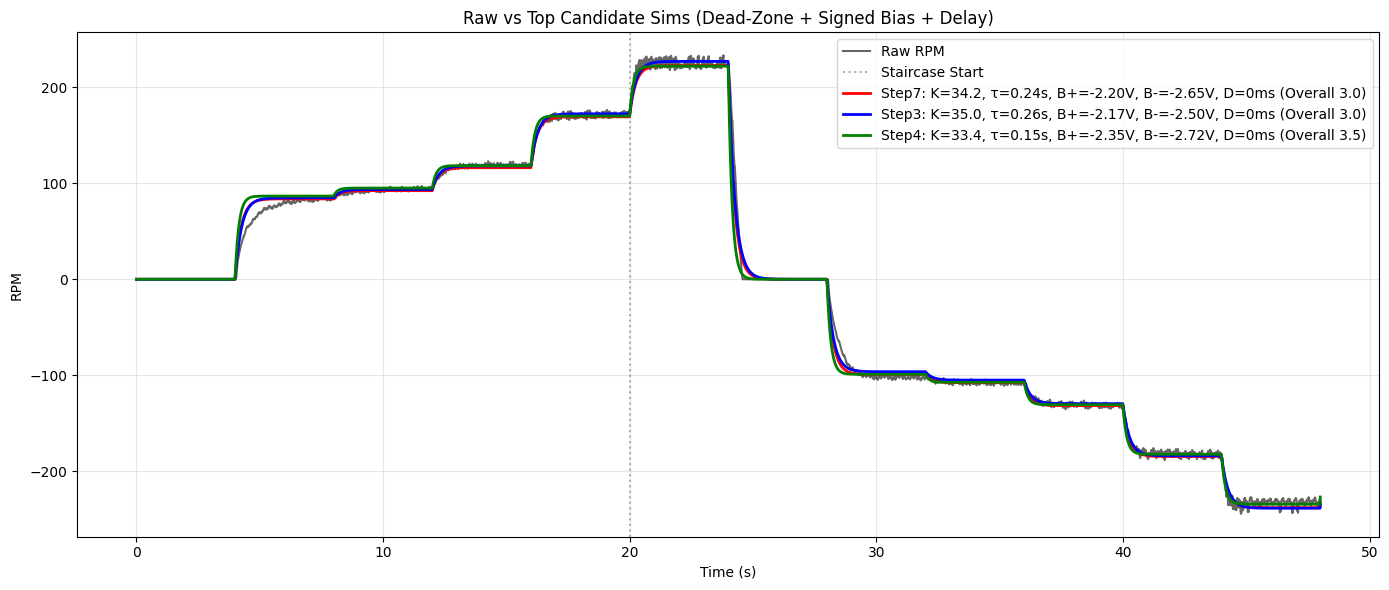

In [21]:
# --- SECTION 7B: Overlay of Top-3 Fits (full run) ---
top = scores_df.nsmallest(3, 'Combined MAE (RPM)')

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(df['time'], df['rpm'].values, 'k-', alpha=0.6, label='Raw RPM', lw=1.5)
ax.axvline(t_stair_start, color='gray', ls=':', alpha=0.6, label='Staircase Start')

colors = ['r','b','g']
for i, (_, row) in enumerate(top.iterrows()):
    name = row['Candidate']
    idx  = [c['name'] for c in candidates].index(name)
    K    = float(candidates[idx]['K'])
    tau  = float(candidates[idx]['tau'])
    Bp   = float(row['U_bias_pos (V)'])
    Bn   = float(row['U_bias_neg (V)'])
    D    = float(row['T_delay (s)'])

    y_sim = sim_full_signed_bias(K, tau, df['u_eff'].values, df['time'].values, Bp, Bn, D)

    ax.plot(df['time'], y_sim, colors[i], lw=2,
            label=f"{name}: K={K:.1f}, τ={tau:.2f}s, B+={Bp:+.2f}V, B-={Bn:+.2f}V, D={int(D*1e3)}ms "
                  f"(Overall {row['Overall MAE (RPM)']:.1f})")

ax.set_xlabel('Time (s)'); ax.set_ylabel('RPM')
# IMPORTANT: do NOT clamp xlim; we want the WHOLE run, including the first 4–5 V steps.
# ax.set_xlim(df['time'].min(), df['time'].max())  # <- optional, but covers full run anyway
ax.set_title('Raw vs Top Candidate Sims (Dead-Zone + Signed Bias + Delay)')
ax.grid(True, alpha=0.3); ax.legend(loc='best')
plt.tight_layout(); plt.savefig(f'{OUT_DIR}/full_overlays_top3.png', dpi=150); plt.show()

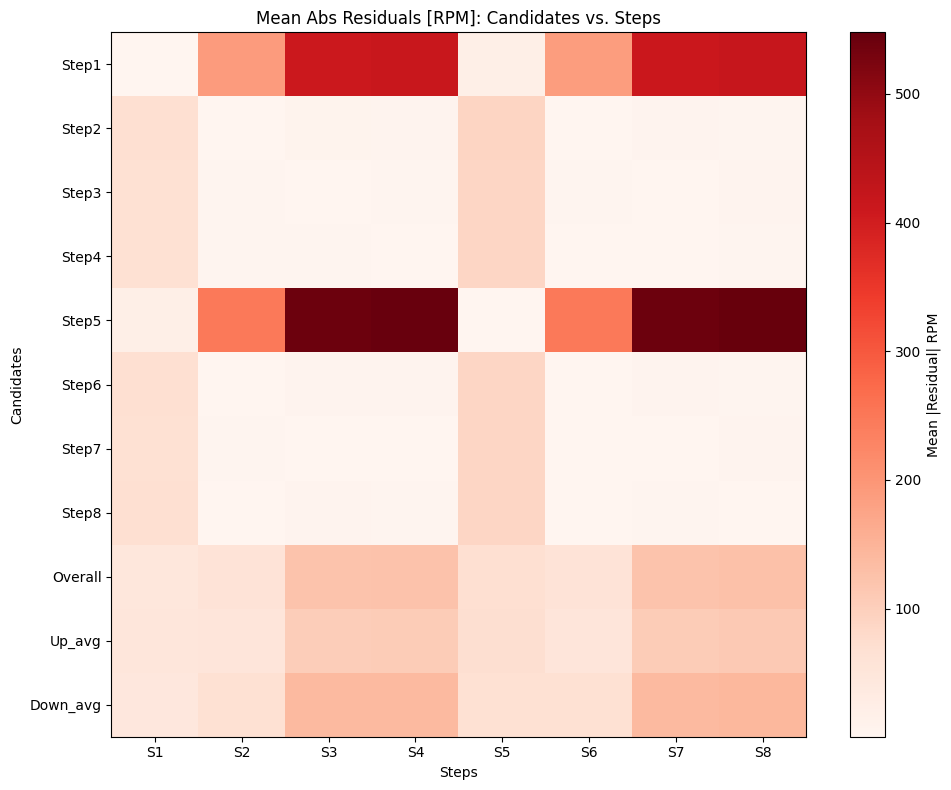

In [22]:
# --- SECTION 7C: Residuals Heatmap (per-step sims; no bias/delay) ---
res_matrix = np.full((len(candidates), len(step_results)), np.nan)
for ci, cand in enumerate(candidates):
    for si, r in enumerate(step_results):
        s, e  = r['start_idx'], r['end_idx']
        t_seg = df['time'].iloc[s:e+1].values - df['time'].iloc[s]
        y_true = df['rpm_id'].iloc[s:e+1].values
        y0 = r['y0']
        y_sim = sim_step_response(t_seg, r['delta_u'], cand['K'], cand['tau'], y0,
                                  u_before=r.get('u_before'), u_after=r.get('u_after'))
        res_matrix[ci, si] = np.mean(np.abs(y_true - y_sim))

fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(res_matrix, cmap='Reds', aspect='auto')
ax.set_xticks(range(len(step_results)))
ax.set_xticklabels([f"S{r['step_num']}" for r in step_results])
ax.set_yticks(range(len(candidates)))
ax.set_yticklabels([c['name'] for c in candidates])
ax.set_ylabel('Candidates'); ax.set_xlabel('Steps')
ax.set_title('Mean Abs Residuals [RPM]: Candidates vs. Steps')
plt.colorbar(im, ax=ax, label='Mean |Residual| RPM')
plt.tight_layout(); plt.savefig(f'{OUT_DIR}/residuals_heatmap.png', dpi=150); plt.show()

## SECTION 8 — Final Parameters + Residuals (your original)

Final plant:
  Dead-zone: +4.50 V / -4.50 V (alpha=0.00)
  Signed bias: B+=-2.200 V, B-=-2.650 V
  Delay: 0 ms
  G(s) = 34.207 / (0.241 s + 1)


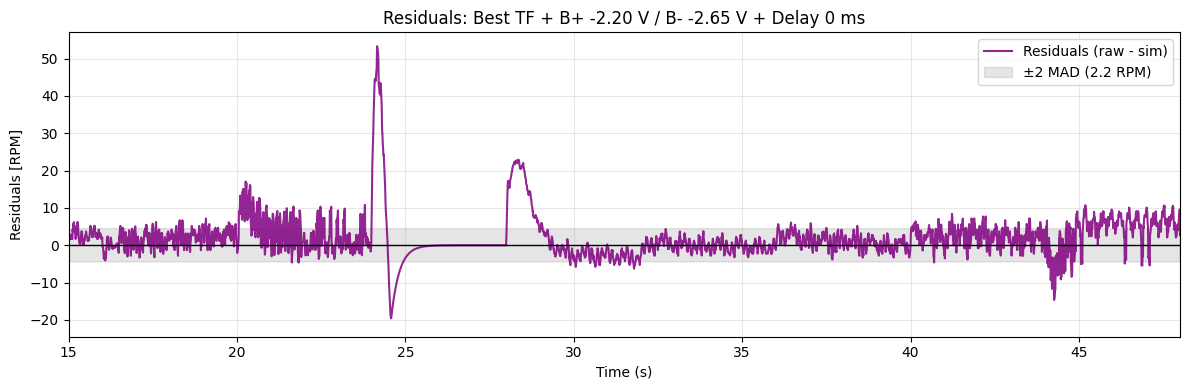

In [23]:
# --- SECTION 8: Final parameters + residuals ---

best_row  = scores_df.loc[scores_df['Combined MAE (RPM)'].idxmin()]
best_name = best_row['Candidate']
cidx      = [c['name'] for c in candidates].index(best_name)
best_K, best_tau = candidates[cidx]['K'], candidates[cidx]['tau']
best_Bp = float(best_row['U_bias_pos (V)'])
best_Bn = float(best_row['U_bias_neg (V)'])
best_D  = float(best_row['T_delay (s)'])

print("Final plant:")
print(f"  Dead-zone: +{VDB_POS:.2f} V / -{VDB_NEG:.2f} V (alpha={SOFT_ALPHA:.2f})")
print(f"  Signed bias: B+={best_Bp:+.3f} V, B-={best_Bn:+.3f} V")
print(f"  Delay: {best_D*1e3:.0f} ms")
print(f"  G(s) = {best_K:.3f} / ({best_tau:.3f} s + 1)")

# export params
pd.DataFrame({
    'Best_Candidate':[best_name],
    'Best_K':[best_K], 'Best_tau':[best_tau],
    'U_bias_pos_V':[best_Bp], 'U_bias_neg_V':[best_Bn], 'T_delay_s':[best_D],
    'DeadZone_PosV':[VDB_POS], 'DeadZone_NegV':[VDB_NEG], 'SoftAlpha':[SOFT_ALPHA],
    'TF_str':[f"{best_K:.3f} / ({best_tau:.3f} s + 1)  with  B+={best_Bp:+.3f} V, B-={best_Bn:+.3f} V, D={best_D:.3f} s"]
}).to_csv(f'{OUT_DIR}/recommended_tf_with_bias_delay.csv', index=False)

# residuals using best signed bias + delay
def overlay_sim_response_signed(K, tau, u_eff, t, Bpos, Bneg, D):
    uD = apply_delay(u_eff, t, D)
    pos = (uD > 0).astype(float); neg = (uD < 0).astype(float)
    y_u   = sim_full_response(K, tau, uD,   t)
    y_pos = sim_full_response(K, tau, pos,  t)
    y_neg = sim_full_response(K, tau, neg,  t)
    return y_u - Bpos*y_pos + Bneg*y_neg

y_sim_best = overlay_sim_response_signed(best_K, best_tau, df['u_eff'].values, df['time'].values,
                                         best_Bp, best_Bn, best_D)
resids = df['rpm'].values - y_sim_best
mask = df['time'].values >= 20.0
mad = stats.median_abs_deviation(resids[mask])

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df['time'], resids, color='purple', alpha=0.85, label='Residuals (raw - sim)')
ax.axhline(0, color='k', lw=1)
ax.fill_between(df['time'], -2*mad, 2*mad, color='gray', alpha=0.2, label=f'±2 MAD ({mad:.1f} RPM)')
ax.set_xlabel('Time (s)'); ax.set_ylabel('Residuals [RPM]')
ax.set_title(f'Residuals: Best TF + B+ {best_Bp:+.2f} V / B- {best_Bn:+.2f} V + Delay {int(best_D*1e3)} ms')
ax.grid(True, alpha=0.3); ax.legend(); ax.set_xlim(15, df['time'].max())
plt.tight_layout(); plt.savefig(f'{OUT_DIR}/final_residuals.png', dpi=150); plt.show()

## SECTION 9 — (Optional) Export LUT & Chebyshev Params

In [14]:
# --- SECTION 9: (Optional) Export LUT & Chebyshev params for Simulink/Docs ---

# LUT export (Voltage breakpoints & PWM values)
lut_export = pd.DataFrame({'Voltage_breakpoints': V_map, 'PWM_values': P_map})
lut_export.to_csv(f'{OUT_DIR}/voltage_to_pwm_LUT.csv', index=False)

# Chebyshev export (if fitted)
if cheby_model is not None:
    import json, pathlib
    cheby_info = {
        'degree': int(cheby_fit['deg']),
        'domain': [float(cheby_model.domain[0]), float(cheby_model.domain[1])],
        'coefficients': [float(c) for c in cheby_model.coef],
        'deadband_voltage_default_pos': float(VDB_POS_DEFAULT),
        'deadband_voltage_default_neg': float(VDB_NEG_DEFAULT),
        'deadband_voltage_estimated': float(V_DEADBAND_EST),
    }
    pathlib.Path(f'{OUT_DIR}/voltage_to_pwm_cheby.json').write_text(json.dumps(cheby_info, indent=2))

print("Exports saved to:", OUT_DIR)

Exports saved to: /content/drive/MyDrive/Master_Archive/60_Academics/Projects/Thesis


## SECTION 10: PI design via Bode/loop-shaping

In [15]:
# --- SECTION 10: PI design via Bode/loop-shaping ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DEG = 180/np.pi

# === Design targets (edit these) ===
PM_TARGET_DEG   = 60.0      # desired phase margin
WC_FACTOR       = 0.5       # target ωc ≈ WC_FACTOR / (τ + D)   (0.3..0.8 is a good range)
GM_MIN_DB       = 6.0       # minimum acceptable gain margin (soft constraint)
W_SAFETY_FACTOR = 0.7       # never push ωc above ~0.7/D (if D>0)

# If the earlier section hasn't run yet (notebook re-ordered), handle gracefully:
try:
    D_USE = float(best_D)
except Exception:
    D_USE = 0.0  # fallback if delay wasn’t estimated

# ---------- Frequency-domain helpers ----------
def plant_freqresp_first_order(K, tau, D, w):
    """G(jw) = K / (1 + j*w*tau) * exp(-j*w*D)"""
    jw = 1j*w
    G = K / (1 + jw*tau)
    if D > 0:
        G *= np.exp(-jw*D)
    return G

def pi_controller_freqresp(Kp, Ti, w):
    """C(jw) = Kp * (1 + 1/(j*w*Ti))"""
    jw = 1j*w
    return Kp * (1 + 1/(jw*Ti))

def unwrap_deg(angle_complex):
    ph = np.unwrap(np.angle(angle_complex))
    return ph * DEG

def margins_from_loop(Lw, w):
    """Return (wc, PM_deg, GM_db, w180) from sampled L(jw)."""
    mag = np.abs(Lw)
    ph_deg = unwrap_deg(Lw)
    # unity gain crossover
    cross = np.where(np.diff(np.sign(mag - 1.0)) != 0)[0]
    wc = np.nan
    if len(cross) > 0:
        i = cross[0]
        # linear interpolate magnitude=1 crossing
        m1, m2 = mag[i], mag[i+1]; w1, w2 = w[i], w[i+1]
        if m2 != m1:
            wc = w1 + (1 - m1) * (w2 - w1) / (m2 - m1)
        else:
            wc = w1
    # phase margin at wc
    PM = np.nan
    if not np.isnan(wc):
        # interp phase at wc
        i = np.searchsorted(w, wc) - 1
        i = np.clip(i, 0, len(w)-2)
        w1, w2 = w[i], w[i+1]
        p1, p2 = ph_deg[i], ph_deg[i+1]
        pha_wc = p1 + (p2 - p1)*(wc - w1)/(w2 - w1)
        PM = 180.0 + pha_wc
    # gain margin at -180°
    # find index where phase is closest to -180
    idx_180 = int(np.argmin(np.abs(ph_deg + 180.0)))
    w180 = w[idx_180]
    gm = 1.0/np.abs(Lw[idx_180])
    GM_db = 20*np.log10(gm)
    return wc, PM, GM_db, w180

def bode_plot(Lw, w, wc=None, PM=None, GM_db=None, w180=None, title='Open-loop Bode with PI'):
    mag = np.abs(Lw); ph = unwrap_deg(Lw)
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,7), sharex=True)
    ax1.semilogx(w, 20*np.log10(mag)); ax1.axhline(0, color='k', lw=0.8)
    ax1.set_ylabel('Magnitude (dB)'); ax1.grid(True, which='both', alpha=0.3)
    if wc is not None and not np.isnan(wc): ax1.axvline(wc, color='r', ls='--', alpha=0.6)

    ax2.semilogx(w, ph); ax2.axhline(-180, color='k', lw=0.8)
    ax2.set_xlabel('ω (rad/s)'); ax2.set_ylabel('Phase (deg)'); ax2.grid(True, which='both', alpha=0.3)
    if wc is not None and not np.isnan(wc): ax2.axvline(wc, color='r', ls='--', alpha=0.6)
    if w180 is not None: ax2.axvline(w180, color='g', ls='--', alpha=0.4)

    txt = []
    if wc is not None and not np.isnan(wc): txt.append(f"ωc≈{wc:.3g} rad/s")
    if PM is not None and not np.isnan(PM): txt.append(f"PM≈{PM:.1f}°")
    if GM_db is not None and not np.isnan(GM_db): txt.append(f"GM≈{GM_db:.1f} dB")
    if txt:
        ax1.set_title(f"{title}  |  " + " , ".join(txt))
    else:
        ax1.set_title(title)
    plt.tight_layout(); plt.show()

# ---------- PI design (loop-shaping sweep) ----------
def design_pi_loopshape(K, tau, D,
                        pm_target=PM_TARGET_DEG,
                        wc_factor=WC_FACTOR,
                        gm_min_db=GM_MIN_DB):
    """
    Pick Kp, Ti by sweeping (ωc_guess, Ti), deriving Kp from unity-gain at ωc_guess,
    then scoring actual PM and ωc of L(jw)=C(jw)G(jw).
    """
    # frequency grid limits
    w_nom = 1.0/max(1e-9, (tau + D))
    w_min = max(1e-3, 0.05/tau)
    w_max_delay = (W_SAFETY_FACTOR/D) if D > 1e-6 else 10.0/tau
    w_low  = max(w_min, 0.25*w_nom)
    w_high = min(2.0*w_nom, w_max_delay)
    if not np.isfinite(w_high) or w_high <= w_low:
        w_high = max(2.0*w_nom, 5.0/tau)

    w = np.logspace(np.log10(w_low), np.log10(w_high), 800)

    # sweep grid
    Ti_vec = np.logspace(np.log10(0.2*tau), np.log10(5.0*tau), 35)
    wc_guess = np.logspace(np.log10(w_low), np.log10(w_high), 35)
    best = {'score': np.inf}

    for Ti in Ti_vec:
        # Precompute plant FRF for speed
        Gw = plant_freqresp_first_order(K, tau, D, w)
        # inner mag/phase of (1 + 1/(jwTi)) * Gw at ωc will determine Kp
        for wc_g in wc_guess:
            # get value at ωc_g (interp)
            i = np.searchsorted(w, wc_g) - 1
            i = np.clip(i, 0, len(w)-2)
            w1, w2 = w[i], w[i+1]
            Gw1, Gw2 = Gw[i], Gw[i+1]
            G_wc = Gw1 + (Gw2 - Gw1) * (wc_g - w1) / (w2 - w1)

            C_shape_wc = (1 + 1/(1j*wc_g*Ti))
            A = np.abs(C_shape_wc * G_wc)
            if A < 1e-12:
                continue
            # choose Kp so that |L(jωc)|=1
            Kp = 1.0 / A
            if not np.isfinite(Kp) or Kp <= 0:
                continue

            # evaluate true margins with this PI
            Cw = pi_controller_freqresp(Kp, Ti, w)
            Lw = Cw * Gw
            wc, PM, GM_db, w180 = margins_from_loop(Lw, w)

            if np.isnan(wc) or np.isnan(PM):
                continue

            # objective: hit PM target and wc near target, keep GM above floor
            w_target = wc_factor * w_nom
            pm_err   = max(0.0, pm_target - PM)  # penalize only if below target
            bw_err   = np.abs(np.log10((wc + 1e-12)/(w_target + 1e-12)))
            gm_pen   = max(0.0, (gm_min_db - (GM_db if np.isfinite(GM_db) else 0.0)))
            score = (pm_err/pm_target)**2 + bw_err**2 + 0.02*(gm_pen**2)

            if score < best['score']:
                best = {
                    'score': score, 'Kp': float(Kp), 'Ti': float(Ti),
                    'Ki': float(Kp/Ti), 'wc': float(wc), 'PM': float(PM),
                    'GM_db': float(GM_db), 'w180': float(w180)
                }
    return best

## SECTION 11: Tune PI for each candidate + summary table

In [16]:
# --- SECTION 11 (BODE): Closed-form PI design per candidate (FOPDT) ---

import numpy as np
import pandas as pd

# Design targets
PM_TARGET_DEG = 60.0      # desired phase margin
GM_MIN_DB     = 6.0       # minimum acceptable gain margin
PHI_MIN_DEG   = 3.0       # avoid extreme Ti from tiny phi_req
PHI_MAX_DEG   = 85.0      # avoid near-90° (integrator dominates)
W_MIN_FACTOR  = 0.05      # lower ω limit ~ 0.05/τ
W_MAX_FACTOR  = 10.0      # upper ω limit ~ 10/τ (further clipped by delay)

PMT = np.deg2rad(PM_TARGET_DEG)
PHI_MIN = np.deg2rad(PHI_MIN_DEG)
PHI_MAX = np.deg2rad(PHI_MAX_DEG)

def design_pi_bode_closed_form(K, tau, D,
                               pm_target_rad=PMT,
                               gm_floor_db=GM_MIN_DB):
    """
    Classic Bode PI design for FOPDT:
    - scan feasible ωc,
    - compute Ti from phase equation,
    - compute Kp from unity-gain equation,
    - check margins, pick fastest feasible solution.
    """
    # ω scan limits (delay limits feasible ω because φ_req must stay > 0)
    w_min = max(1e-3, W_MIN_FACTOR / max(tau, 1e-9))
    # crude upper bound: don't go past where atan(wτ) + wD approaches (π - PM)
    # use a generous numeric grid and let feasibility test discard bad points
    w_delay_cap = (W_MAX_FACTOR / max(tau, 1e-9))  # start high; feasibility will trim
    w = np.logspace(np.log10(w_min), np.log10(w_delay_cap), 1200)

    best = None
    for wc in w:
        phi_req = np.pi - pm_target_rad - np.arctan(wc*tau) - wc*D
        # Feasible phi_req range
        if not (PHI_MIN < phi_req < PHI_MAX):
            continue

        Ti = 1.0 / (wc * np.tan(phi_req))
        if not np.isfinite(Ti) or Ti <= 0:
            continue

        magCshape = np.sqrt(1.0 + (1.0/(wc*Ti))**2)
        magG      = K / np.sqrt(1.0 + (wc*tau)**2)
        if magCshape*magG <= 0:
            continue

        Kp = 1.0 / (magCshape * magG)
        if not np.isfinite(Kp) or Kp <= 0:
            continue

        # Evaluate true margins
        wplot = np.logspace(np.log10(max(wc/12, w_min)), np.log10(wc*12), 1600)
        Gw = plant_freqresp_first_order(K, tau, D, wplot)
        Cw = pi_controller_freqresp(Kp, Ti, wplot)
        Lw = Cw * Gw
        wc_meas, PM_meas, GM_db, w180 = margins_from_loop(Lw, wplot)

        # Accept if PM and GM meet targets (allow tiny numeric slack)
        if (not np.isnan(PM_meas)) and (not np.isnan(wc_meas)) and (PM_meas >= PM_TARGET_DEG - 0.5) and (GM_db >= gm_floor_db - 0.2):
            # Choose the FASTEST (max wc_meas)
            key = (wc_meas, PM_meas, GM_db)
            if (best is None) or (key > best['key']):
                best = {
                    'key': key,
                    'Kp': float(Kp), 'Ti': float(Ti), 'Ki': float(Kp/Ti),
                    'wc': float(wc_meas), 'PM': float(PM_meas), 'GM_db': float(GM_db),
                    'note': 'PM & GM met'
                }

    # If nothing meets both PM and GM, fall back to "closest" (best PM with GM >= 0 dB)
    if best is None:
        fallback = None
        for wc in w:
            phi_req = np.pi - pm_target_rad - np.arctan(wc*tau) - wc*D
            if not (PHI_MIN < phi_req < PHI_MAX): continue
            Ti = 1.0 / (wc * np.tan(phi_req))
            if not np.isfinite(Ti) or Ti <= 0:   continue
            magCshape = np.sqrt(1.0 + (1.0/(wc*Ti))**2)
            magG      = K / np.sqrt(1.0 + (wc*tau)**2)
            if magCshape*magG <= 0:              continue
            Kp = 1.0 / (magCshape * magG)
            if not np.isfinite(Kp) or Kp <= 0:   continue

            wplot = np.logspace(np.log10(max(wc/12, w_min)), np.log10(wc*12), 1600)
            Lw = pi_controller_freqresp(Kp, Ti, wplot) * plant_freqresp_first_order(K, tau, D, wplot)
            wc_meas, PM_meas, GM_db, _ = margins_from_loop(Lw, wplot)
            if np.isnan(PM_meas): continue
            if GM_db < 0:         continue  # unstable tendency
            score = (PM_TARGET_DEG - PM_meas)**2 + max(0.0, GM_MIN_DB - GM_db)**2
            if (fallback is None) or (score < fallback['score']) or (score == fallback['score'] and wc_meas > fallback['wc']):
                fallback = {
                    'score': score,
                    'Kp': float(Kp), 'Ti': float(Ti), 'Ki': float(Kp/Ti),
                    'wc': float(wc_meas), 'PM': float(PM_meas), 'GM_db': float(GM_db),
                    'note': 'Relaxed: GM/PM not fully met'
                }
        if fallback is not None:
            best = fallback

    return best  # may be None if everything failed

# ---- Run design for selected candidates ----
# Prefer Top-3 + Overall + Up_avg + Down_avg (if present), else all
try:
    preferred = list(top['Candidate'])
except Exception:
    preferred = []
all_names = [c['name'] for c in candidates]
want = []
for nm in preferred + ['Overall','Up_avg','Down_avg'] + all_names:
    if nm in all_names and nm not in want:
        want.append(nm)

rows = []
for nm in want:
    c = next((x for x in candidates if x['name']==nm), None)
    if c is None or not np.isfinite(c['K']) or not np.isfinite(c['tau']):
        continue
    res = design_pi_bode_closed_form(float(c['K']), float(c['tau']), float(best_D))
    if res is None:
        continue
    rows.append({
        'Candidate': nm,
        'K': float(c['K']), 'tau': float(c['tau']), 'Delay D (s)': float(best_D),
        'Kp': res['Kp'], 'Ki': res['Ki'], 'Ti': res['Ti'],
        'ωc (rad/s)': res['wc'], 'PM (deg)': res['PM'], 'GM (dB)': res['GM_db'],
        'Note': res['note']
    })

pi_bode = pd.DataFrame(rows).sort_values(['Note','ωc (rad/s)'], ascending=[True, False]).reset_index(drop=True)
pi_bode_round = pi_bode.copy()
for col in ['K','tau','Delay D (s)','Kp','Ki','Ti','ωc (rad/s)','PM (deg)','GM (dB)']:
    pi_bode_round[col] = pi_bode_round[col].astype(float).round(3)

pi_bode_round

,Candidate,K,tau,Delay D (s),Kp,Ki,Ti,ωc (rad/s),PM (deg),GM (dB),Note
0,Step8,31.029,0.138,0.0,0.016,0.394,0.042,8.432,60.0,5.817,PM & GM met
1,Step4,33.359,0.152,0.0,0.015,0.333,0.046,7.657,60.0,5.817,PM & GM met
2,Step7,34.207,0.241,0.0,0.015,0.206,0.073,4.853,60.0,5.817,PM & GM met
3,Step3,35.050,0.263,0.0,0.015,0.184,0.079,4.441,60.0,5.817,PM & GM met
4,Down_avg,131.236,0.297,0.0,0.004,0.043,0.090,3.936,60.0,5.817,PM & GM met
5,Overall,120.435,0.315,0.0,0.004,0.045,0.095,3.710,60.0,5.817,PM & GM met
6,Up_avg,109.634,0.333,0.0,0.005,0.046,0.100,3.508,60.0,5.817,PM & GM met
7,Step6,31.617,0.373,0.0,0.016,0.144,0.113,3.133,60.0,5.817,PM & GM met
8,Step2,31.261,0.432,0.0,0.016,0.125,0.130,2.702,60.0,5.817,PM & GM met
9,Step5,428.092,0.435,0.0,0.001,0.009,0.131,2.685,60.0,5.817,PM & GM met


## SECTION 12: Bode plot for best PI (lowest Score)

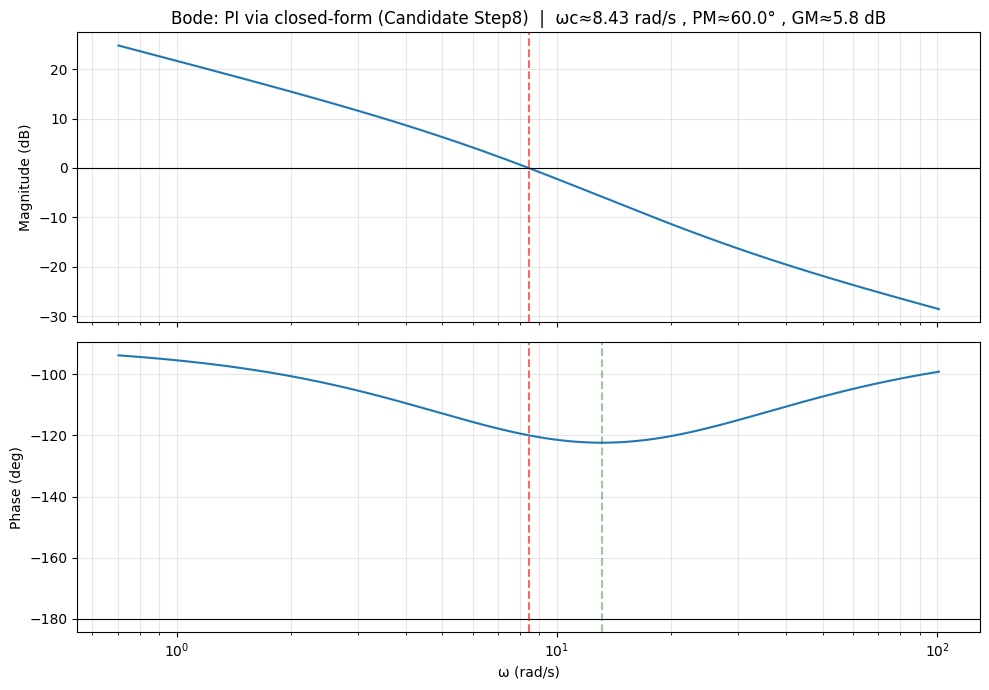

Recommended PI (Bode) for Step8:  Kp=0.016,  Ki=0.394  (Ti=0.042 s)
Margins:  ωc≈8.432 rad/s,  PM≈60.0°,  GM≈5.8 dB   |   Note: PM & GM met


In [17]:
# --- SECTION 12 (BODE): Bode of recommended PI & reported margins ---

assert len(pi_bode) > 0, "No Bode-plot PI designs found. Try lowering PM_TARGET_DEG or GM_MIN_DB."

best_row = pi_bode.iloc[0]
name = best_row['Candidate']
K, tau, D = best_row['K'], best_row['tau'], best_row['Delay D (s)']
Kp, Ti    = best_row['Kp'], best_row['Ti']

# Frequency grid centered around measured crossover
w_nom = best_row['ωc (rad/s)']
w = np.logspace(np.log10(max(w_nom/12, 0.05/max(tau,1e-6))),
                np.log10(max(w_nom*12, w_nom*1.2)),
                1600)

Gw = plant_freqresp_first_order(K, tau, D, w)
Cw = pi_controller_freqresp(Kp, Ti, w)
Lw = Cw * Gw
wc, PM, GM_db, w180 = margins_from_loop(Lw, w)

bode_plot(Lw, w, wc=wc, PM=PM, GM_db=GM_db, w180=w180,
          title=f"Bode: PI via closed-form (Candidate {name})")

print(f"Recommended PI (Bode) for {name}:  Kp={Kp:.3f},  Ki={Kp/Ti:.3f}  (Ti={Ti:.3f} s)")
print(f"Margins:  ωc≈{wc:.3f} rad/s,  PM≈{PM:.1f}°,  GM≈{GM_db:.1f} dB   |   Note: {best_row['Note']}")

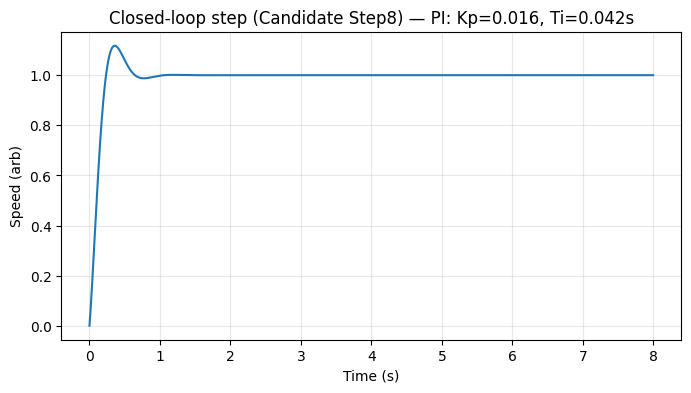

In [18]:
# --- SECTION 13: Closed-loop step check (linear plant + delay) ---
# This is a quick sanity check in time domain for the chosen PI. It ignores dead-zone/bias/PWM map.

from scipy.signal import dlti, dlsim
from scipy.signal import lti, lsim

# Continuous-time closed-loop with delay approximated by Pade(1,1) for a quick view
def pade_11(D):
    # (1 - sD/2) / (1 + sD/2)
    return [ -D/2, 1 ], [ D/2, 1 ]

def cont_closed_loop_step(K, tau, D, Kp, Ti, T=10.0, dt=0.002):
    s_num_C = [Kp*Ti, Kp]      # Kp*(Ti*s + 1) / (Ti*s)
    s_den_C = [Ti, 0.0]        # Ti*s

    # PI * First-order plant
    # C(s)G(s) = (Kp*(Ti*s+1)/(Ti*s)) * (K/(tau*s+1)) * Delay
    # Use Pade(1,1) for delay
    if D > 1e-9:
        num_d, den_d = pade_11(D)
    else:
        num_d, den_d = [1.0], [1.0]

    # multiply transfer functions: C * G * delay
    # (num_C/den_C)*(K/(tau s + 1))*(num_d/den_d)
    from numpy.polynomial import polynomial as P
    num_C = s_num_C; den_C = s_den_C
    num_G = [K];     den_G = [tau, 1.0]
    num = np.poly1d(np.convolve(np.convolve(num_C, num_G), num_d))
    den = np.poly1d(np.convolve(np.convolve(den_C, den_G), den_d))

    # Closed-loop: T(s) = L(s)/(1+L(s)) where L= C*G*delay
    L = lti(num, den)
    # 1/(1+L) is not trivial in scipy; do feedback via hand composition:
    # T(s) = Num_L / (Den_L + Num_L)
    Num_L = np.asarray(L.num); Den_L = np.asarray(L.den)
    Num_T = Num_L
    Den_T = np.polyadd(Den_L, Num_L)
    Tsys  = lti(Num_T, Den_T)

    t = np.arange(0, T, dt)
    u = np.ones_like(t)  # unit step
    tout, y, _ = lsim(Tsys, U=u, T=t)
    return tout, y

t, y = cont_closed_loop_step(K, tau, D, Kp, Ti, T= max(8*(tau+D), 8.0))
plt.figure(figsize=(8,4))
plt.plot(t, y)
plt.xlabel('Time (s)'); plt.ylabel('Speed (arb)')
plt.title(f'Closed-loop step (Candidate {name}) — PI: Kp={Kp:.3f}, Ti={Ti:.3f}s')
plt.grid(True, alpha=0.3)
plt.show()